In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIze = 256
CHANNELS = 3
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIze,IMAGE_SIze),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 0 1 0 0 1 0 0 1 0 2 1 0 0 1 0 0 0 1 1 1 1 2 1 2 0 0 0 0 0 0 1]


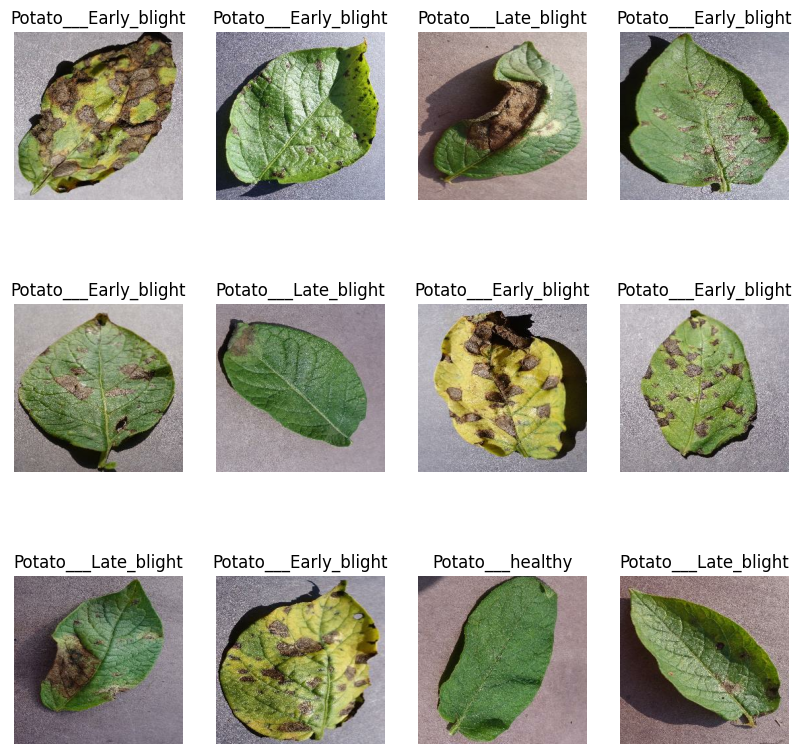

In [5]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitision_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    assert(train_split+test_split+val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
        
    return train_ds, val_ds, test_ds

In [7]:
train_ds,val_ds,test_ds = get_dataset_partitision_tf(dataset)

In [8]:
len(train_ds)

54

In [9]:
len(val_ds)

6

In [10]:
# cache put image in to memory and will reduce the training time from loading form disk
train_ds = train_ds.cache().shuffle (1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle (1000).prefetch (buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle (1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.45490196 0.4117647  0.44313726]
  [0.4862745  0.44313726 0.4745098 ]
  [0.5019608  0.45882353 0.49019608]
  ...
  [0.47843137 0.43529412 0.45882353]
  [0.46666667 0.42352942 0.44705883]
  [0.42745098 0.38431373 0.40784314]]

 [[0.45490196 0.4117647  0.44313726]
  [0.47843137 0.43529412 0.46666667]
  [0.4862745  0.44313726 0.4745098 ]
  ...
  [0.4745098  0.43137255 0.45490196]
  [0.46666667 0.42352942 0.44705883]
  [0.43529412 0.39215687 0.41568628]]

 [[0.45490196 0.4117647  0.44313726]
  [0.4627451  0.41960785 0.4509804 ]
  [0.45882353 0.41568628 0.44705883]
  ...
  [0.49019608 0.44705883 0.47058824]
  [0.4862745  0.44313726 0.46666667]
  [0.47058824 0.42745098 0.4509804 ]]

 ...

 [[0.6117647  0.5921569  0.61960787]
  [0.60784316 0.5882353  0.6156863 ]
  [0.6039216  0.58431375 0.6117647 ]
  ...
  [0.61960787 0.5921569  0.62352943]
  [0.6117647  0.58431375 0.6156863 ]
  [0.60784316 0.5803922  0.6117647 ]]

 [[0.58431375 0.5647059  0.5921569 ]
  [0.5882353  0.5686275  0.59607846]


In [12]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIze, IMAGE_SIze),
    layers.experimental.preprocessing.Rescaling(1.0/255)
]
)

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
]
)

In [14]:
#CNN
input_shape = (BATCH_SIZE, IMAGE_SIze, IMAGE_SIze, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

Epoch 1/30
54/54 [==============================] - 69s 1s/step - loss: 0.9239 - accuracy: 0.4670 - val_loss: 0.8560 - val_accuracy: 0.5104
Epoch 2/30
54/54 [==============================] - 61s 1s/step - loss: 0.7121 - accuracy: 0.6765 - val_loss: 0.5888 - val_accuracy: 0.7448
Epoch 3/30
54/54 [==============================] - 58s 1s/step - loss: 0.4462 - accuracy: 0.8113 - val_loss: 0.3818 - val_accuracy: 0.8385
Epoch 4/30
54/54 [==============================] - 58s 1s/step - loss: 0.3113 - accuracy: 0.8727 - val_loss: 0.2531 - val_accuracy: 0.8958
Epoch 5/30
54/54 [==============================] - 57s 1s/step - loss: 0.2706 - accuracy: 0.8912 - val_loss: 0.2161 - val_accuracy: 0.9010
Epoch 6/30
54/54 [==============================] - 58s 1s/step - loss: 0.2176 - accuracy: 0.9115 - val_loss: 0.2084 - val_accuracy: 0.8958
Epoch 7/30
54/54 [==============================] - 58s 1s/step - loss: 0.1558 - accuracy: 0.9410 - val_loss: 0.1246 - val_accuracy: 0.9479
Epoch 8/30
54/54 [==

In [18]:
model.evaluate(test_ds)

8/8 [==============================] - 3s 219ms/step - loss: 0.0055 - accuracy: 0.9961


[0.005457027815282345, 0.99609375]

In [19]:
history

In [20]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
len(history.history['accuracy'])

30

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

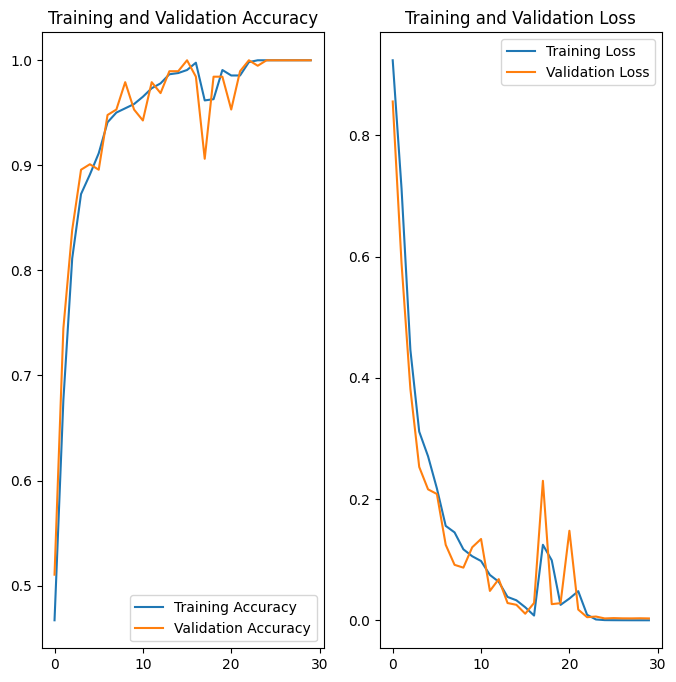

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 281ms/step
predicted label: Potato___Late_blight


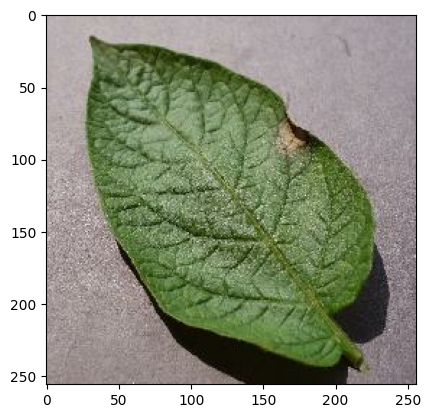

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 25ms/step


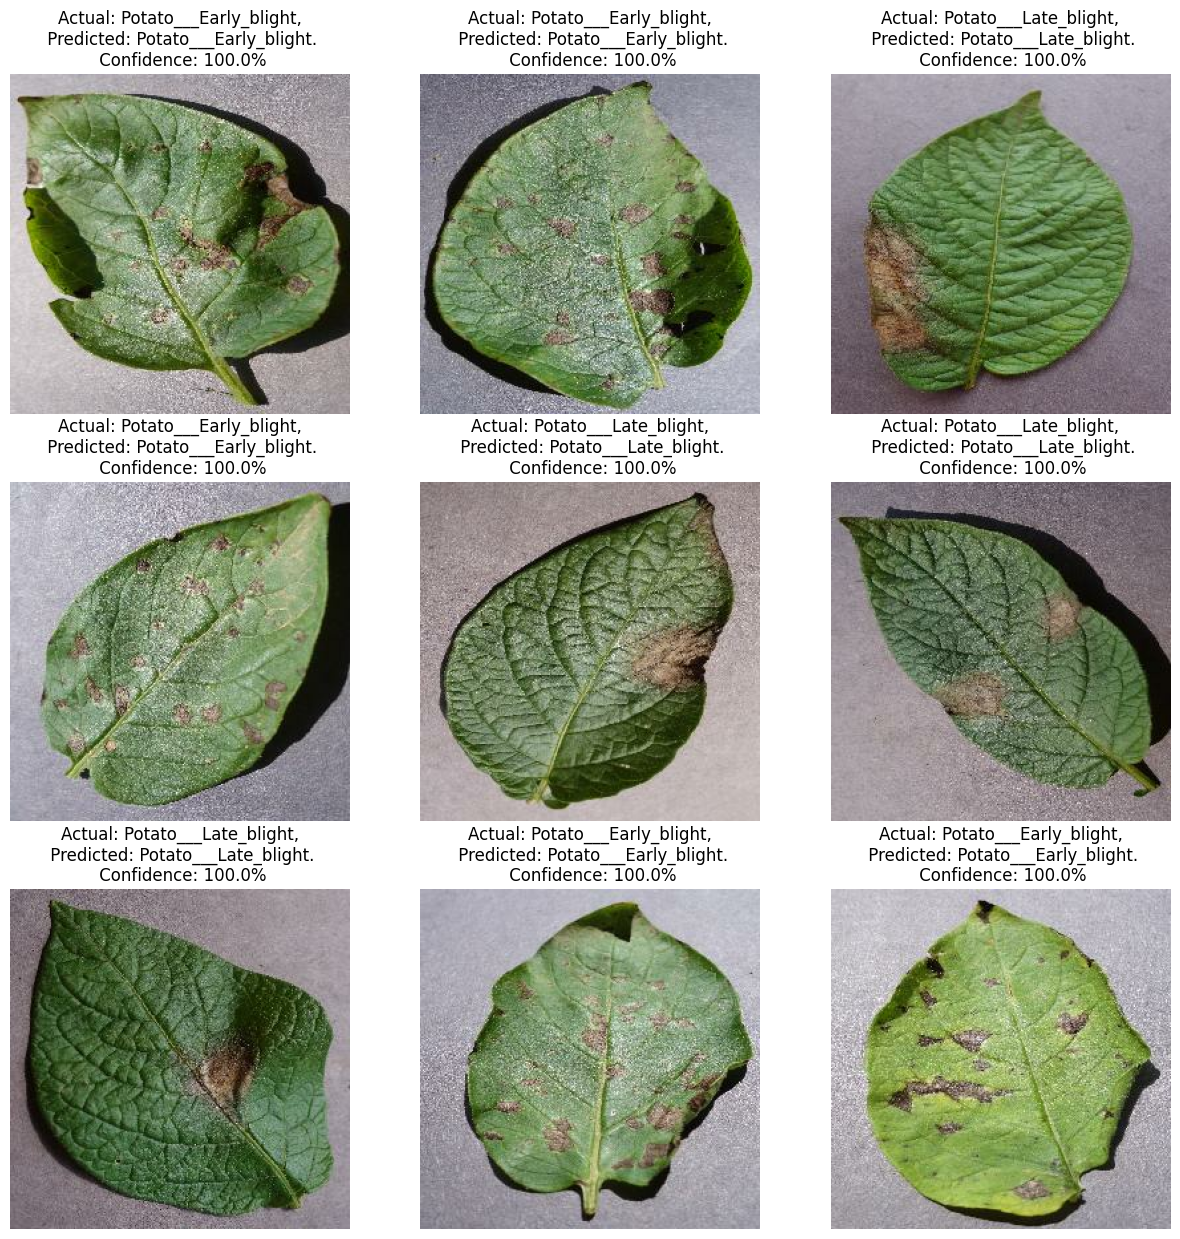

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [47]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
